<a href="https://colab.research.google.com/github/LittleAri/ALICE/blob/main/ALICE_demo_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ALICE Demo Setup

Tests for the ALICE Demo.

Scroll to the bottom of the notebook to run the example "demo" function.

#### Image / Weights Path:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Imports / Installs


If using Google Colab, make sure to load all the files within the source_functions and Mask_RCNN_Files folders from the ALICE repository.

In [ ]:
!pip install tensorflow==1.15.5
!pip install keras==2.3.1
!pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install numpy==1.21.5
!pip install pytesseract

In [2]:
import os
import sys
import random
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
from google.colab import files
import tqdm
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore")
import config
# Import Mask RCNN
import utils
import model as modellib
import visualize
# Import COCO config
import coco
import re
import pandas as pd
%matplotlib inline
from main import find_aligned_label
from label_merging import align_merged_label
import PIL
import skimage.io as io

Instructions for updating:
non-resource variables are not supported in the long term
Using TensorFlow backend.


#### Functions

In [6]:
def resize_image(image_path,basewidth=2048):
  image = PIL.Image.open(image_path)
  wpercent = (basewidth / float(image.size[0]))
  hsize = int((float(image.size[1]) * float(wpercent)))
  img = image.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
  I = np.asarray(img)
  return I

In [3]:
def cnn_segment(weights_path,class_names,image_path,plot=True,loaded_image=[]):
  try:
    del model, config_
  except:
    pass

  class InferenceConfig(coco.CocoConfig):
      # Set batch size to 1 since we'll be running inference on
      # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
      GPU_COUNT = 1
      IMAGES_PER_GPU = 1
      NUM_CLASSES = 2

  config_ = InferenceConfig()

  # Create model object in inference mode.
  model = modellib.MaskRCNN(mode="inference", model_dir=' ', config=config_)

  # Load weights trained on ALICE data
  model.load_weights(weights_path, by_name=True)

  # Load image
  if len(loaded_image) == 0:
    image = skimage.io.imread(image_path)
  else:
    image = deepcopy(loaded_image)

  # Run detection
  results = model.detect([image], verbose=0)
  r = results[0]

  if plot == True:
    fig,ax = plt.subplots()
    # Visualize results
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'],ax=ax)

  res = r['masks']
  return image, res

In [4]:
def colour_pin_mask(masks,image):
  msk_img = deepcopy(image)
  v= np.shape(masks)[-1]
  for i in range(0,v):
      msk_img[np.where(masks[:,:,i]==True)] = [255,0,0]
  return msk_img

In [12]:
def find_top_label(msks_,method="highest"):

  all_lens = []
  p = np.shape(msks_)[-1]
  for i in range(0,p):
    all_lens.append(len(np.where(msks_[:,:,i]==True)[0]))

  if method == "highest":
    bound = np.percentile(all_lens,25)

    a = [min(np.where(msks_[:,:,i]==True)[0]) for i in range(0,p) if all_lens[i] > bound ]

    b = [i for i in range(0,p) if all_lens[i] > bound]

    k = b[np.argmin(a)]

  elif method == "largest":
    k = np.argmax(all_lens)

  return msks_[:,:,k]

### Segmentation Tests

#### Pin:

In [19]:
path_w = 'drive/My Drive/ALICE/mask_rcnn_pin.h5'
path_i = 'drive/My Drive/ALICE/balloon/val/013612432_additional_4.JPG'
c_names = ['BG', 'pin']

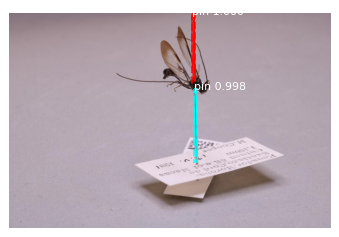

In [24]:
img,msk = cnn_segment(path_w,c_names,path_i)

In [ ]:
m = colour_pin_mask(msk,img)

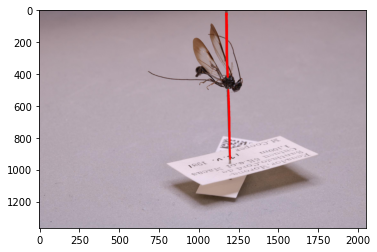

In [ ]:
fig,ax = plt.subplots()
ax.imshow(m)

#### Label:

In [ ]:
path_w = 'drive/My Drive/ALICE/mask_rcnn_label_resized.h5'
c_names = ['BG','label']

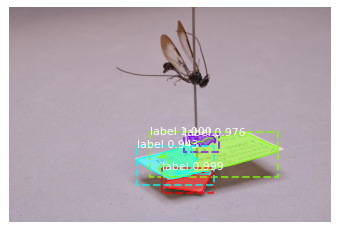

In [ ]:
I,m = cnn_segment(path_w,c_names,path_i)

#### Sample:

In [7]:
all_sample = []

for file in os.listdir('drive/My Drive/ALICE/sample'):
  all_sample.append(file)

In [8]:
all_ids = []

for nm in all_sample:
  id_ = nm[:re.search("_",nm).span()[0]]
  all_ids.append(id_)

In [9]:
df_files = pd.DataFrame([all_sample,all_ids]).T

In [10]:
df_files = df_files.rename(columns={0:'filename',1:'id'})

In [11]:
unq_IDs = np.unique(list(df_files['id']))

### Top Label Tests

Tests to find the top label. 

Default in find_top_label function is "highest" label, but this could be changed to method="largest".

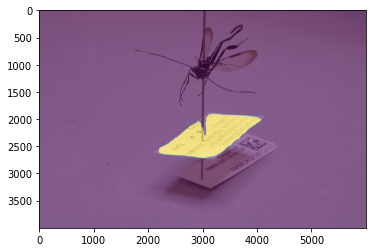

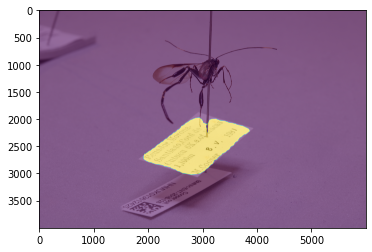

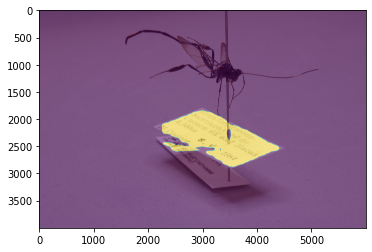

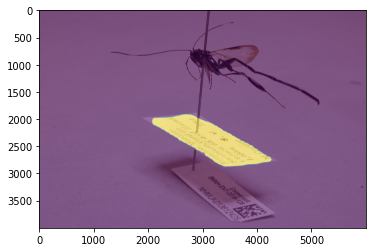

In [ ]:
files = list(df_files[df_files['id']==unq_IDs[0]]['filename'])

path = 'drive/My Drive/ALICE/sample'

path_w = 'drive/My Drive/ALICE/mask_rcnn_label_resized.h5'
c_names = ['BG','label']

for i in range(0,4):
  path_i = path+'/'+files[i]

  I,m = cnn_segment(path_w,c_names,path_i,plot=False)

  lab = find_top_label(m)

  fig,ax = plt.subplots()
  ax.imshow(I)
  ax.imshow(lab,alpha=0.5)

### Demo Test!

#### Segmentation Step

In [15]:
details_dict = {}


files_ = np.sort(list(df_files[df_files['id']=='013612439']['filename']))

path = 'drive/My Drive/ALICE/sample'

path_w_lab = 'drive/My Drive/ALICE/mask_rcnn_label_resized.h5'
path_w_pin = 'drive/My Drive/ALICE/mask_rcnn_pin.h5'
classes_lab = ['BG','label']
classes_pin = ['BG','pin']

for i in range(0,4):
  path_i = path+'/'+files_[i]

  img = io.imread(path_i)
  if np.shape(img)[1] > 2048:
    img = resize_image(path_i)

  _,mask_label = cnn_segment(path_w_lab,classes_lab,path_i,plot=False,loaded_image=img)
  _,mask_pin = cnn_segment(path_w_pin,classes_pin,path_i,plot=False,loaded_image=img)

  img_pin = colour_pin_mask(mask_pin,img)
  top_label = find_top_label(mask_label,method="largest")
  details_dict.update({i:{"image":img,"mask_l":top_label,"mask_p":img_pin}})


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead
Instructions for updating:
Use `tf.cast` instead.



#### Label Finding/Aligning Step

In [16]:
all_images,transformed,merged = find_aligned_label(None,details_dict,None,paths=False,
            remove_pin=True,template_option=2,ydist=True,align=True,
            combine_extra_masks = True,template_label=None,merge_method=0,filter_imgs=True)

aligned = align_merged_label(merged)
        

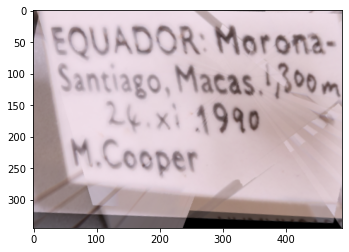

In [17]:
fig,ax = plt.subplots()
ax.imshow(aligned)